## Model to predict Remaining Useful Life (RUL) on an engine after each run cycle to improve the Predictive Maintenance process
_**Single machine training for regression with Amazon SageMaker XGBoost algorithm**_

---

---
## Contents
1. [Introduction](#Introduction)
2. [Setup](#Setup)
  1. [Fetching the dataset](#Fetching-the-dataset)
  2. [Data Ingestion](#Data-ingestion)
3. [Training the XGBoost model](#Training-the-XGBoost-model)
  1. [Plotting evaluation metrics](#Plotting-evaluation-metrics)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
  1. [Import model into hosting](#Import-model-into-hosting)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
5. [Validate the model for use](#Validate-the-model-for-use)

---
## Introduction

This notebook demonstrates the use of Amazon SageMaker’s implementation of the XGBoost algorithm to train and host a regression model. 
NASA's Prognostic Center of Excellence established a repository with datasets to be used for benchmarking prognostics and predictive maintenance related algorithms. Among these datasets involves data from a turbofan engine simulation model C-MAPPS (or Commercial Modular Aero Propulsion System Simulation). C-MAPPS is a tool used to generate health, control and engine parameters from a simulated turbofan engine. A custom code wrapper was used to inject synthetic faults and continuous degradation trends into a time series of sensor data. Some high level characteristics of this dataset are as follows:

1. The data obtained is from a high fidelity simulation of a turbofan engine, but closely models the sensor values of an actual engine.
2. Synthetic noise was added to the dataset to replicate real-world scenarios.
3. _The effects of faults are masked due to operational conditions_, which is a common trait of most real world systems.

Download the dataset here - https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan. 

---
## Setup


This notebook was created and tested on an ml.m4.4xlarge notebook instance.

Let's start by specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
%%time
import sagemaker
import os
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import os 
 
region = boto3.Session().region_name    
smclient = boto3.Session().client('sagemaker')

role = sagemaker.get_execution_role()

bucket = sagemaker.Session().default_bucket()                     
prefix = 'PredictiveMaintenance-Team-9'

CPU times: user 971 ms, sys: 154 ms, total: 1.13 s
Wall time: 1.32 s


In [3]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

bucket='s3://sagemaker-us-east-1-023375022819' 
prefix = 'PredictiveMaintenance-Team-9'

bucket_path = '{}/{}/'.format(bucket, prefix)
bucket_path

CPU times: user 1.04 s, sys: 118 ms, total: 1.16 s
Wall time: 8.86 s


In [4]:
inputPath = bucket_path + "input/"
inputPath

's3://sagemaker-us-east-1-023375022819/PredictiveMaintenance-Team-9/input/'

In [5]:
!pwd

/home/ec2-user/SageMaker/PredictiveMaintenance


In [6]:
import pandas as pd

### Train Data Setup

For each Type of dataset: FD001, FD002, FD003, FD004, do as below
1. Create a new variables for Conditions: 1 - ONE (Sea Level) or 2 - SIX
2. Create a new variable for FaultMode: 1 - ONE (HPC Degradation) or 2 -TWO (HPC Degradation, Fan Degradation)
3. One-Hot Encoding, Create columns condition-1, condition-2, faultMode-1, faultMode-2. So for dataset 
    - **FD001, the combo would be 1,0,1,0** 
    - **FD002, the combo would be 0,1,1,0** 
    - **FD003, the combo would be 1,0,0,1** 
    - **FD004, the combo would be 0,1,0,1** 
4. Create target variable, output (RUL), which is calculated as finding the max cycle for that engine, assiging that as output value for first RUL corresponding to first cycle and decrementing that by one within that engine. This is a naive assumption, that the degradation starts at the very first cycle. Deeper understanding and research can performed to find the threshold value when actual degradation could have started to get a more accurate RUL.
5. Once all train_FD00~ are wrangled, concatenate them
6. Remove unecessary columns

#### Train FD001

In [7]:
tr_1 = pd.read_csv('train_FD001.txt', sep = " ", header = None)
df1 = pd.DataFrame(tr_1)

df1['Conditions']='1'
df1['Fault_mode']='1'
#df1.head()
df2 = df1.loc[:, [0,1]]
df2.columns = ['c1', 'c2']
my_dict = {}
for index, row in df2.iterrows():
    col1 = row['c1']
    col2 = row['c2']
    if not col1 in my_dict:
        my_dict[col1] = col2
    else:
        if col2 > my_dict[col1]:
            my_dict[col1] = col2
#print(my_dict)
output = []
for key in sorted(my_dict.keys()):
    for i in reversed(range(my_dict[key])):
        output.append(i)

df1['output'] = output
#df1.head()
cols = list(df1.columns)
cols = [cols[-1]] + cols[:-1]
traindf1 = df1[cols]
traindf1.head()

,output,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,Conditions,Fault_mode
0,191,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,...,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,1,1
1,190,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,...,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,1,1
2,189,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,...,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,1,1
3,188,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,...,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,1,1
4,187,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,...,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,1,1


#### Train FD002

In [8]:
tr_1 = pd.read_csv('train_FD002.txt', sep=" ", header=None)
df1 = pd.DataFrame(tr_1)

df1['Conditions']='2'
df1['Fault_mode']='1'
#df1.head()
df2=df1.loc[:, [0,1]]
df2.columns = ['c1', 'c2']
my_dict = {}
for index, row in df2.iterrows():
    col1 = row['c1']
    col2 = row['c2']
    if not col1 in my_dict:
        my_dict[col1] = col2
    else:
        if col2 > my_dict[col1]:
            my_dict[col1] = col2
#print(my_dict)
output = []
for key in sorted(my_dict.keys()):
    for i in reversed(range(my_dict[key])):
        output.append(i)

df1['output'] = output
#df1.head()
cols = list(df1.columns)
cols = [cols[-1]] + cols[:-1]
traindf2 = df1[cols]
traindf2.head()

,output,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,Conditions,Fault_mode
0,148,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,...,0.02,334,2223,100.00,14.73,8.8071,NaN,NaN,2,1
1,147,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,...,0.02,330,2212,100.00,10.41,6.2665,NaN,NaN,2,1
2,146,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,...,0.02,309,1915,84.93,14.08,8.6723,NaN,NaN,2,1
3,145,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,...,0.02,329,2212,100.00,10.59,6.4701,NaN,NaN,2,1
4,144,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,...,0.02,309,1915,84.93,14.13,8.5286,NaN,NaN,2,1


#### Train FD003

In [9]:
tr_1 = pd.read_csv('train_FD003.txt', sep=" ", header=None)
df1 = pd.DataFrame(tr_1)

df1['Conditions']='1'
df1['Fault_mode']='2'
#df1.head()
df2=df1.loc[:, [0,1]]
df2.columns = ['c1', 'c2']
my_dict = {}
for index, row in df2.iterrows():
    col1 = row['c1']
    col2 = row['c2']
    if not col1 in my_dict:
        my_dict[col1] = col2
    else:
        if col2 > my_dict[col1]:
            my_dict[col1] = col2
#print(my_dict)
output = []
for key in sorted(my_dict.keys()):
    for i in reversed(range(my_dict[key])):
        output.append(i)

df1['output'] = output
#df1.head()
cols = list(df1.columns)
cols = [cols[-1]] + cols[:-1]
traindf3 = df1[cols]
traindf3.head()

,output,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,Conditions,Fault_mode
0,258,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,...,0.03,391,2388,100.0,39.11,23.3537,NaN,NaN,1,2
1,257,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,...,0.03,392,2388,100.0,38.99,23.4491,NaN,NaN,1,2
2,256,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,...,0.03,391,2388,100.0,38.85,23.3669,NaN,NaN,1,2
3,255,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,...,0.03,392,2388,100.0,38.96,23.2951,NaN,NaN,1,2
4,254,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,...,0.03,392,2388,100.0,39.14,23.4583,NaN,NaN,1,2


#### Train FD004

In [10]:
tr_1 = pd.read_csv('train_FD004.txt', sep=" ", header=None)
df1 = pd.DataFrame(tr_1)

df1['Conditions']='2'
df1['Fault_mode']='2'
#df1.head()
df2=df1.loc[:, [0,1]]
df2.columns = ['c1', 'c2']
my_dict = {}
for index, row in df2.iterrows():
    col1 = row['c1']
    col2 = row['c2']
    if not col1 in my_dict:
        my_dict[col1] = col2
    else:
        if col2 > my_dict[col1]:
            my_dict[col1] = col2
#print(my_dict)
output = []
for key in sorted(my_dict.keys()):
    for i in reversed(range(my_dict[key])):
        output.append(i)

df1['output'] = output
#df1.head()
cols = list(df1.columns)
cols = [cols[-1]] + cols[:-1]
traindf4 = df1[cols]
traindf4.head()

,output,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,Conditions,Fault_mode
0,320,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,0.02,330,2212,100.00,10.62,6.3670,NaN,NaN,2,2
1,319,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,0.02,361,2324,100.00,24.37,14.6552,NaN,NaN,2,2
2,318,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,0.02,329,2212,100.00,10.48,6.4213,NaN,NaN,2,2
3,317,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,0.02,328,2212,100.00,10.54,6.4176,NaN,NaN,2,2
4,316,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,0.02,305,1915,84.93,14.03,8.6754,NaN,NaN,2,2


In [11]:
#Row bind the train data sets
pdList = [traindf1, traindf2, traindf3, traindf4]  # List of your dataframes
train_df = pd.concat(pdList)

In [12]:
#Drop unnecessary columns
train_df.drop([1, 26,27], inplace=True,axis = 1) 

In [13]:
train_df.head()

,output,0,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,Conditions,Fault_mode
0,191,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,1
1,190,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1,1
2,189,1,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1,1
3,188,1,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1,1
4,187,1,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1,1


In [14]:
train_df.shape

(160359, 28)

In [15]:
#Create new columns, using one hot encoding
train_df = pd.get_dummies(train_df, columns = ['Conditions','Fault_mode'])

In [16]:
train_df.head()

,output,0,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,Conditions_1,Conditions_2,Fault_mode_1,Fault_mode_2
0,191,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.4190,1,0,1,0
1,190,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.03,392,2388,100.0,39.00,23.4236,1,0,1,0
2,189,1,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.03,390,2388,100.0,38.95,23.3442,1,0,1,0
3,188,1,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.03,392,2388,100.0,38.88,23.3739,1,0,1,0
4,187,1,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.03,393,2388,100.0,38.90,23.4044,1,0,1,0


In [17]:
train_df.tail()

,output,0,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,Conditions_1,Conditions_2,Fault_mode_1,Fault_mode_2
61244,4,249,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,0.03,372,2319,100.0,29.11,17.5234,0,1,0,1
61245,3,249,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,0.03,396,2388,100.0,39.38,23.7151,0,1,0,1
61246,2,249,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,0.03,395,2388,100.0,39.78,23.8270,0,1,0,1
61247,1,249,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,0.02,337,2223,100.0,15.26,9.0774,0,1,0,1
61248,0,249,42.0030,0.8400,100.0,445.00,549.85,1369.75,1147.45,3.91,...,0.02,333,2212,100.0,10.66,6.4341,0,1,0,1


In [18]:
train_df.describe()

,output,0,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,Conditions_1,Conditions_2,Fault_mode_1,Fault_mode_2
count,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,...,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000,160359.000000
mean,122.331338,105.553758,17.211973,0.410004,95.724344,485.840890,597.361022,1467.035653,1260.956434,9.894999,...,0.025185,360.698801,2273.754039,98.389146,25.942709,15.565700,0.282809,0.717191,0.463897,0.536103
std,83.538146,72.867325,16.527988,0.367938,12.359044,30.420388,42.478516,118.175261,136.300073,4.265554,...,0.004997,31.021430,142.513114,4.656270,11.691422,7.015067,0.450366,0.450366,0.498696,0.498696
min,0.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.480000,1242.670000,1023.770000,3.910000,...,0.020000,302.000000,1915.000000,84.930000,10.160000,6.010500,0.000000,0.000000,0.000000,0.000000
25%,56.000000,44.000000,0.001300,0.000200,100.000000,449.440000,549.960000,1357.360000,1126.830000,5.480000,...,0.020000,332.000000,2212.000000,100.000000,14.330000,8.601300,0.000000,0.000000,0.000000,0.000000
50%,113.000000,89.000000,19.998100,0.620000,100.000000,489.050000,605.930000,1492.810000,1271.740000,9.350000,...,0.030000,367.000000,2319.000000,100.000000,24.920000,14.953500,0.000000,1.000000,0.000000,1.000000
75%,172.000000,164.000000,35.001500,0.840000,100.000000,518.670000,642.340000,1586.590000,1402.200000,14.620000,...,0.030000,392.000000,2388.000000,100.000000,38.820000,23.294600,1.000000,1.000000,1.000000,1.000000
max,542.000000,260.000000,42.008000,0.842000,100.000000,518.670000,645.110000,1616.910000,1441.490000,14.620000,...,0.030000,400.000000,2388.000000,100.000000,39.890000,23.950500,1.000000,1.000000,1.000000,1.000000


In [19]:
train_df.corr()

,output,0,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,Conditions_1,Conditions_2,Fault_mode_1,Fault_mode_2
output,1.000000,-0.012765,-0.010300,-0.011275,0.006096,0.010684,0.004582,-0.020455,-0.032047,0.010733,...,-0.031191,-0.020581,0.009915,0.006096,0.014697,0.014656,0.014851,-0.014851,-0.158932,0.158932
0,-0.012765,1.000000,0.312532,0.333547,-0.100764,-0.323789,-0.318260,-0.307855,-0.317691,-0.332286,...,-0.286560,-0.308730,-0.238296,-0.100764,-0.332439,-0.332424,-0.479273,0.479273,0.044168,-0.044168
2,-0.010300,0.312532,1.000000,0.967487,-0.163079,-0.979797,-0.925472,-0.877521,-0.909480,-0.991539,...,-0.901542,-0.879403,-0.619531,-0.163079,-0.977664,-0.977674,-0.653946,0.653946,0.007363,-0.007363
3,-0.011275,0.333547,0.967487,1.000000,-0.197923,-0.939207,-0.898218,-0.867189,-0.912110,-0.965691,...,-0.932897,-0.869323,-0.623632,-0.197923,-0.959658,-0.959656,-0.699745,0.699745,0.008600,-0.008600
4,0.006096,-0.100764,-0.163079,-0.197923,1.000000,0.264989,0.493244,0.601374,0.539436,0.230742,...,0.359027,0.598086,0.870889,1.000000,0.344868,0.344814,0.217244,-0.217244,-0.002038,0.002038
5,0.010684,-0.323789,-0.979797,-0.939207,0.264989,1.000000,0.969407,0.926589,0.943456,0.992550,...,0.873423,0.928151,0.704665,0.264989,0.987856,0.987864,0.677681,-0.677681,-0.007335,0.007335
6,0.004582,-0.318260,-0.925472,-0.898218,0.493244,0.969407,1.000000,0.989141,0.988864,0.954472,...,0.879724,0.989728,0.857009,0.493244,0.979178,0.979172,0.668165,-0.668165,-0.004689,0.004689
7,-0.020455,-0.307855,-0.877521,-0.867189,0.601374,0.926589,0.989141,1.000000,0.993401,0.911783,...,0.878761,0.998944,0.914698,0.601374,0.952101,0.952087,0.649107,-0.649107,0.001854,-0.001854
8,-0.032047,-0.317691,-0.909480,-0.912110,0.539436,0.943456,0.988864,0.993401,1.000000,0.936864,...,0.912335,0.993885,0.877577,0.539436,0.969753,0.969742,0.670551,-0.670551,0.006286,-0.006286
9,0.010733,-0.332286,-0.991539,-0.965691,0.230742,0.992550,0.954472,0.911783,0.936864,1.000000,...,0.892455,0.913622,0.675427,0.230742,0.992562,0.992570,0.695596,-0.695596,-0.007834,0.007834


### Test Data Wrangling

For each Type of test dataset: FD001, FD002, FD003, FD004, do as below
1. Create a new variables for Conditions: 1 - ONE (Sea Level) or 2 - SIX
2. Create a new variable for FaultMode: 1 - ONE (HPC Degradation) or 2 -TWO (HPC Degradation, Fan Degradation)
3. One-Hot Encoding, Create columns condition-1, condition-2, faultMode-1, faultMode-2. So for dataset 
    - **FD001, the combo would be 1,0,1,0** 
    - **FD002, the combo would be 0,1,1,0** 
    - **FD003, the combo would be 1,0,0,1** 
    - **FD004, the combo would be 0,1,0,1** 
4. Create target variable, output (RUL), which is calculated as finding the max cycle for that engine, from the RUL_FD00~.txt file, assiging that as output value for first RUL corresponding to first cycle and decrementing that by one within that engine. 
5. Once all test_FD00~ are wrangled, concatenate them
6. Remove unecessary columns

In [31]:
t_1 = pd.read_csv('test_FD001.txt', sep = " ", header = None)
r_1 = pd.read_csv('RUL_FD001.txt', sep = " ", header = None)
r_1 = r_1.reset_index()
r_1["EngineNo"] = r_1.index + 1
r1 = r_1[[0, 'EngineNo']]
t1 = t_1.rename(columns = {0:'EngineNo'})
test1 = pd.merge(r1, t1, on = 'EngineNo', how = 'inner')
df1 = pd.DataFrame(test1)

df1['Conditions'] ='1'
df1['Fault_mode'] ='1'

df2 = df1.groupby(by = "EngineNo")[1].max()

test1 = pd.merge(df1, df2, on = 'EngineNo', how = 'inner')
test1.head()
test1['output'] = test1[0] + test1['1_y'] - test1['1_x']
cols = list(test1.columns)
cols = [cols[-1]] + cols[:-1]
test1 = test1[cols]
test1.head()

,output,0,EngineNo,1_x,2,3,4,5,6,7,...,21,22,23,24,25,26,27,Conditions,Fault_mode,1_y
0,142,112,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,...,392,2388,100.0,38.86,23.3735,NaN,NaN,1,1,31
1,141,112,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,...,393,2388,100.0,39.02,23.3916,NaN,NaN,1,1,31
2,140,112,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,...,393,2388,100.0,39.08,23.4166,NaN,NaN,1,1,31
3,139,112,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,...,391,2388,100.0,39.00,23.3737,NaN,NaN,1,1,31
4,138,112,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,...,390,2388,100.0,38.99,23.4130,NaN,NaN,1,1,31


In [32]:
t_1 = pd.read_csv('test_FD002.txt', sep = " ", header=None)
r_1 = pd.read_csv('RUL_FD002.txt', sep = " ", header=None)
r_1 = r_1.reset_index()
r_1["EngineNo"] = r_1.index + 1
r1 = r_1[[0, 'EngineNo']]
t1 = t_1.rename(columns ={0:'EngineNo'})
test2 = pd.merge(r1, t1, on = 'EngineNo',how = 'inner')
df1 = pd.DataFrame(test2)

df1['Conditions'] = '2'
df1['Fault_mode'] = '1'

df2 = df1.groupby(by = "EngineNo")[1].max()

test2 = pd.merge(df1, df2, on = 'EngineNo',how = 'inner')
test2.head()
test2['output'] = test2[0] + test2['1_y'] - test2['1_x']
cols = list(test2.columns)
cols = [cols[-1]] + cols[:-1]
test2 = test2[cols]
test2.head()

,output,0,EngineNo,1_x,2,3,4,5,6,7,...,21,22,23,24,25,26,27,Conditions,Fault_mode,1_y
0,275,18,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,...,369,2319,100.00,28.42,17.1551,NaN,NaN,2,1,258
1,274,18,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,...,364,2324,100.00,24.29,14.8039,NaN,NaN,2,1,258
2,273,18,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,...,333,2223,100.00,14.98,8.9125,NaN,NaN,2,1,258
3,272,18,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,...,332,2212,100.00,10.35,6.4181,NaN,NaN,2,1,258
4,271,18,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,...,305,1915,84.93,14.31,8.5740,NaN,NaN,2,1,258


In [33]:
t_1 = pd.read_csv('test_FD003.txt', sep = " ", header=None)
r_1 = pd.read_csv('RUL_FD003.txt', sep = " ", header=None)
r_1 = r_1.reset_index()
r_1["EngineNo"] = r_1.index + 1
r1 = r_1[[0, 'EngineNo']]
t1 = t_1.rename(columns = {0:'EngineNo'})
test3 = pd.merge(r1, t1, on = 'EngineNo',how = 'inner')
df1 = pd.DataFrame(test3)

df1['Conditions'] = '1'
df1['Fault_mode'] = '2'

df2 = df1.groupby(by = "EngineNo")[1].max()

test3 = pd.merge(df1, df2, on = 'EngineNo', how = 'inner')
test3.head()
test3['output'] = test3[0] + test3['1_y'] - test3['1_x']
cols = list(test3.columns)
cols = [cols[-1]] + cols[:-1]
test3 = test3[cols]
test3.head()

,output,0,EngineNo,1_x,2,3,4,5,6,7,...,21,22,23,24,25,26,27,Conditions,Fault_mode,1_y
0,276,44,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,...,391,2388,100.0,39.07,23.4468,NaN,NaN,1,2,233
1,275,44,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,...,391,2388,100.0,39.04,23.4807,NaN,NaN,1,2,233
2,274,44,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,...,391,2388,100.0,39.10,23.4244,NaN,NaN,1,2,233
3,273,44,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,...,392,2388,100.0,38.97,23.4782,NaN,NaN,1,2,233
4,272,44,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,...,391,2388,100.0,39.09,23.3950,NaN,NaN,1,2,233


In [34]:
t_1 = pd.read_csv('test_FD004.txt', sep = " ", header = None)
r_1 = pd.read_csv('RUL_FD004.txt', sep = " ", header = None)
r_1 = r_1.reset_index()
r_1["EngineNo"] = r_1.index + 1
r1 = r_1[[0, 'EngineNo']]
t1 = t_1.rename(columns = {0:'EngineNo'})
test4 = pd.merge(r1, t1, on = 'EngineNo', how = 'inner')
df1 = pd.DataFrame(test4)

df1['Conditions'] = '1'
df1['Fault_mode'] = '2'

df2 = df1.groupby(by = "EngineNo")[1].max()

test4 = pd.merge(df1, df2, on = 'EngineNo', how = 'inner')
test4.head()
test4['output'] = test4[0] + test4['1_y'] - test4['1_x']
cols = list(test4.columns)
cols = [cols[-1]] + cols[:-1]
test4 = test4[cols]
test4.head()

,output,0,EngineNo,1_x,2,3,4,5,6,7,...,21,22,23,24,25,26,27,Conditions,Fault_mode,1_y
0,251,22,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,...,362,2324,100.00,24.31,14.7007,NaN,NaN,1,2,230
1,250,22,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,...,306,1915,84.93,14.36,8.5748,NaN,NaN,1,2,230
2,249,22,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,...,328,2212,100.00,10.39,6.4365,NaN,NaN,1,2,230
3,248,22,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,...,328,2212,100.00,10.56,6.2367,NaN,NaN,1,2,230
4,247,22,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,...,333,2223,100.00,14.85,8.9326,NaN,NaN,1,2,230


In [35]:
# Row Bind the test datasets
pdList = [test1, test2, test3, test4]  # List of your dataframes
test_df = pd.concat(pdList)

In [36]:
#Drop unnecessary columns
test_df.drop([0, '1_x','1_y',26,27], inplace=True, axis = 1) 

In [37]:
test_df.shape

(104897, 28)

In [38]:
test_df = pd.get_dummies(test_df, columns = ['Conditions','Fault_mode'])

In [39]:
test_df.shape


(104897, 30)

In [40]:
test_df.describe()

,output,EngineNo,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,Conditions_1,Conditions_2,Fault_mode_1,Fault_mode_2
count,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,...,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000,104897.000000
mean,162.628264,103.119117,17.243810,0.410887,95.748591,485.791314,597.153354,1464.738375,1257.240382,9.887805,...,0.025039,360.088096,2273.841797,98.398282,25.949868,15.570426,0.675958,0.324042,0.448888,0.551112
std,80.873737,71.370362,16.530141,0.368078,12.328151,30.426804,42.430629,117.856835,135.728855,4.265536,...,0.005000,30.932463,142.218102,4.644631,11.701010,7.020590,0.468018,0.468018,0.497383,0.497383
min,6.000000,1.000000,-0.008700,-0.000600,60.000000,445.000000,535.410000,1240.940000,1024.900000,3.910000,...,0.020000,302.000000,1915.000000,84.930000,10.180000,6.123100,0.000000,0.000000,0.000000,0.000000
25%,107.000000,43.000000,0.001300,0.000200,100.000000,449.440000,549.780000,1355.140000,1124.030000,5.480000,...,0.020000,331.000000,2212.000000,100.000000,14.340000,8.607300,0.000000,0.000000,0.000000,0.000000
50%,154.000000,87.000000,19.998200,0.620000,100.000000,489.050000,605.530000,1490.160000,1262.850000,9.350000,...,0.030000,367.000000,2319.000000,100.000000,24.780000,14.872400,1.000000,0.000000,0.000000,1.000000
75%,206.000000,159.000000,35.001500,0.840000,100.000000,518.670000,642.200000,1584.810000,1399.460000,14.620000,...,0.030000,392.000000,2388.000000,100.000000,38.880000,23.331000,1.000000,1.000000,1.000000,1.000000
max,553.000000,259.000000,42.008000,0.842000,100.000000,518.670000,644.320000,1609.690000,1434.120000,14.620000,...,0.030000,398.000000,2388.000000,100.000000,39.750000,23.849600,1.000000,1.000000,1.000000,1.000000


In [41]:
test_df.head()

,output,EngineNo,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,Conditions_1,Conditions_2,Fault_mode_1,Fault_mode_2
0,142,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,0.03,392,2388,100.0,38.86,23.3735,1,0,1,0
1,141,1,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,0.03,393,2388,100.0,39.02,23.3916,1,0,1,0
2,140,1,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,0.03,393,2388,100.0,39.08,23.4166,1,0,1,0
3,139,1,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,0.03,391,2388,100.0,39.00,23.3737,1,0,1,0
4,138,1,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,0.03,390,2388,100.0,38.99,23.4130,1,0,1,0


In [42]:
#Save the train data
train_df.to_csv('train_final.csv', header=False, index=False)

In [43]:
#Save the Test data
test_df.to_csv('test.csv', header=False, index=False)

In [44]:
%%time

import io
import boto3
import random

#def data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST):
def data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, PERCENT_TRAIN, PERCENT_VALIDATION):
    data = [l for l in open(FILE_DATA, 'r')]
    train_file = open(FILE_TRAIN, 'w')
    valid_file = open(FILE_VALIDATION, 'w')
    #tests_file = open(FILE_TEST, 'w')

    num_of_data = len(data)
    num_train = int((PERCENT_TRAIN/100.0)*num_of_data)
    num_valid = int((PERCENT_VALIDATION/100.0)*num_of_data)
    #num_tests = int((PERCENT_TEST/100.0)*num_of_data)

    data_fractions = [num_train, num_valid]#, num_tests]
    split_data = [[],[]]#,[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data)-1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file.write(l)

    for l in split_data[1]:
        valid_file.write(l)

    #for l in split_data[2]:
    #    tests_file.write(l)

    train_file.close()
    valid_file.close()
    #tests_file.close()
    

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.6 µs


### Fetching the dataset

Following methods split the train data further into train/validation datasets and upload files to S3.

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training. This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [45]:
%%time
import urllib.request

# Load the dataset
FILE_DATA = 'train_final.csv'
#urllib.request.urlretrieve("https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan", FILE_DATA)

#split the downloaded data into train/test/validation files
FILE_TRAIN = 'train.csv'
FILE_VALIDATION = 'valid.csv'

FILE_TEST = "test.csv"
PERCENT_TRAIN = 80
PERCENT_VALIDATION = 20

#PERCENT_TEST = 15
#data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST)
data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, PERCENT_TRAIN, PERCENT_VALIDATION)

CPU times: user 3 s, sys: 48 ms, total: 3.05 s
Wall time: 3.07 s


In [203]:
def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

In [204]:
bucket='sagemaker-us-east-1-023375022819'
prefix = 'PredictiveMaintenance-Team-9/model-data'

In [205]:
upload_to_s3(bucket, 'train', FILE_TRAIN)

Writing to s3://sagemaker-us-east-1-023375022819/PredictiveMaintenance-Team-9/model-data/train/train.csv


In [206]:
upload_to_s3(bucket, 'validation', FILE_VALIDATION)

Writing to s3://sagemaker-us-east-1-023375022819/PredictiveMaintenance-Team-9/model-data/validation/valid.csv


In [208]:
upload_to_s3(bucket, 'test', FILE_TEST)

Writing to s3://sagemaker-us-east-1-023375022819/PredictiveMaintenance-Team-9/model-data/test/test.csv


## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 5 and 6 minutes.

In [46]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost')

In [47]:
bucket_path = 's3://sagemaker-us-east-1-023375022819/PredictiveMaintenance-Team-9'

In [48]:
prefix = 'model-data'

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost', repo_version='latest')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='rmse',
                        objective='reg:linear',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

In [4]:
hyperparameter_ranges = {'eta': ContinuousParameter(0.3, 0.7),
                        'min_child_weight': ContinuousParameter(5, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(4, 8)}

In [44]:
objective_metric_name = 'validation:rmse'

In [45]:
tuner = HyperparameterTuner(estimator=xgb,
                            objective_metric_name=objective_metric_name,
                            objective_type='Minimize',
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

In [41]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

In [46]:
print(bucket)
prefix='PredictiveMaintenance-Team-9/model-data'
print(prefix)

s3_data='s3://{}/{}/validation/'.format(bucket, prefix)
print(s3_data)

sagemaker-us-east-1-023375022819
PredictiveMaintenance-Team-9/model-data
s3://sagemaker-us-east-1-023375022819/PredictiveMaintenance-Team-9/model-data/validation/


In [ ]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

In [ ]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

In [222]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'PredictiveMaintenance-xgboost-regression-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

#Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/single-xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 5
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "silent":"0",
        "objective":"reg:linear",
        "num_round":"50"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/train',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/validation',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        }
    ]
}

client = boto3.client('sagemaker', region_name=region)
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

Training job PredictiveMaintenance-xgboost-regression-2019-08-28-19-43-13
InProgress
InProgress
InProgress
Completed
CPU times: user 73.7 ms, sys: 204 µs, total: 73.9 ms
Wall time: 3min


Note that the "validation" channel has been initialized too. The SageMaker XGBoost algorithm actually calculates RMSE and writes it to the CloudWatch logs on the data passed to the "validation" channel.

### Plotting evaluation metrics
Evaluation metrics for the completed training job are available in CloudWatch. We can pull the area under curve metric for the validation data set and plot it to see the performance of the model over time.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


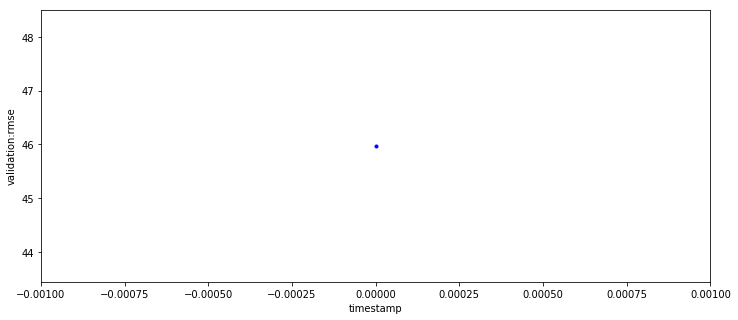

In [220]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = 'validation:rmse'

metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name, metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

## Set up hosting for the model
In order to set up hosting, we have to import the model from training to hosting. 

### Import model into hosting

Register the model with hosting. This allows the flexibility of importing models trained elsewhere.

In [ ]:
%%time
import boto3
from time import gmtime, strftime

model_name = job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

### Create endpoint configuration

SageMaker supports configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way. In addition, the endpoint configuration describes the instance type required for model deployment.

In [ ]:
from time import gmtime, strftime

endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [ ]:
%%time
import time

endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName = endpoint_name,
    EndpointConfigName = endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

## Validate the model for use
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [ ]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

Start with a single prediction.

In [ ]:
!head -1 abalone.test > abalone.single.test

In [ ]:
%%time
import json
from itertools import islice
import math
import struct

file_name = 'abalone.single.test' #customize to your test file
with open(file_name, 'r') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/x-libsvm', 
                                   Body=payload)
result = response['Body'].read()
result = result.decode("utf-8")
result = result.split(',')
result = [math.ceil(float(i)) for i in result]
label = payload.strip(' ').split()[0]
print ('Label: ',label,'\nPrediction: ', result[0])

OK, a single prediction works. Let's do a whole batch to see how good is the predictions accuracy.

In [ ]:
import sys
import math
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName = endpoint_name, 
                                   ContentType = content_type, 
                                   Body = payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    preds = [math.ceil(num) for num in preds]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

The following helps us calculate the Median Absolute Percent Error (MdAPE) on the batch dataset. 

In [ ]:
FILE_TEST='test.csv'

In [ ]:
%%time
import json
import numpy as np

with open(FILE_TEST, 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100, endpoint_name, 'text/x-libsvm')

print('\n Median Absolute Percent Error (MdAPE) = ', np.median(np.abs(np.array(labels) - np.array(preds)) / np.array(labels)))

### Delete Endpoint
Once you are done using the endpoint, you can use the following to delete it. 

In [ ]:
client.delete_endpoint(EndpointName=endpoint_name)